<h1 style="text-align: center;"> Performance comparison of different optimization algorithm for image classification </h1>

<h4 style="text-align: center;"> CS-439: Optimization for Machine Learning - Project </h4>

<h5 style="text-align: center;"> Edouard Dufour, Yassamine Saidi, Monika Stoilova </h5>


<style>
body {
text-align: justify}
</style>

In this notebook, we implement different opitmization algorithms for image classification on the MNIST dataset. The algoithms we aim to compare are Stochastic Gradient Descent (SGD), Momentum SGD, Adaptive Momentum Estimation (ADAM) and Lion. 

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from dataset import get_MNIST_data
from model import CNN
from lion_pytorch import Lion as pytorch_Lion
import time
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
TRAIN_SPLIT = 0.75
BATCH_SIZE = 64
EPOCHS = 10

In [45]:
traindata, testdata, valdata = get_MNIST_data(TRAIN_SPLIT)
traindataloader = DataLoader(traindata, batch_size=BATCH_SIZE)
valdataloader = DataLoader(valdata, batch_size=BATCH_SIZE)
testdataloader = DataLoader(testdata, batch_size=BATCH_SIZE)

# Calculate steps per epoch for training and validation set
trainsteps = len(traindataloader.dataset) // BATCH_SIZE
valsteps = len(valdataloader.dataset) // BATCH_SIZE

In [76]:
# List of optimizers to be compared
optimizers = ['Adam', "SGD", "Momentum SGD", "Lion"]

# Empty dictionary to store training loss results
train_loss_results = {}

# Empty dictionary to store validation loss results
val_loss_results = {}

# Empty dictionary to store training accuracy results
train_acc_results = {}

# Empty dictionary to store validation accuracy results
val_acc_results = {}

In [77]:
# Loop over all optimizers 

for opt_name in optimizers:
    
    # Print name of the current optimizer 
    print(f"[INFO] current optimizer: {opt_name}.")
    
    # Initialize the CNN model 
    print("[INFO] initializing the CNN model...")
    model = CNN(layers=[{"in_ch": 1, "out_ch": 10, "conv_k_sz": 5, "maxp_k_sz": 2, "maxp_str": 2}], num_classes=10, lin_features=1960).to(device)
    
    # Define the optimizer 
    if opt_name == "Adam":
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    elif opt_name == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=1e-3)
    elif opt_name == "Momentum SGD":
        opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    elif opt_name == "Lion":
        opt = pytorch_Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
    
    # Define loss function
    lossFn = torch.nn.NLLLoss()
    
    # Define dictionary to store training and validation loss at each step
    H = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    
    # ---- Train the model using the current optimizer ----
    
    print(f"[INFO] training the network with {opt_name} optimizer...")
    
    startTime = time.time()
    
    # Loop over our epochs
    for e in range(0, EPOCHS):
        
        # Set the model in training mode
        model.train()
        
        # Initialize the total training and validation loss
        totalTrainLoss = 0
        totalValLoss = 0
        
        # Initialize the number of correct predictions in the training
        # and validation step
        trainCorrect = 0
        valCorrect = 0
        
        # Loop over the training set
        for (x, y) in traindataloader:
            
            # Send the input to the device
            (x, y) = (x.to(device), y.to(device))
            
            # Perform a forward pass and calculate the training loss
            pred = model(x)
            loss = lossFn(pred, y)
            
            # Zero out the gradients, perform the backpropagation step,
            # and update the weights
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            # Add the loss to the total training loss so far and
            # calculate the number of correct predictions
            totalTrainLoss += loss
            trainCorrect += (pred.argmax(1) == y).type(
                torch.float).sum().item()

        # Switch off autograd for evaluation
        with torch.no_grad():
            
            # Set the model in evaluation mode
            model.eval()
            
            # Loop over the validation set
            for (x, y) in valdataloader:
                
                # Send the input to the device
                (x, y) = (x.to(device), y.to(device))
                
                # Make the predictions
                pred = model(x)
                
                # Compute the validation loss
                totalValLoss += lossFn(pred, y)
                
                # Compute the number of correct predictions
                valCorrect += (pred.argmax(1) == y).type(
                    torch.float).sum().item()
        
        # Compute the average training and validation loss
        avgTrainLoss = totalTrainLoss / trainsteps
        avgValLoss = totalValLoss / valsteps
        
        # Compute the training and validation accuracy
        trainCorrect = trainCorrect / len(traindataloader.dataset)
        valCorrect = valCorrect / len(valdataloader.dataset)
        
        # Update our training history
        H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
        H["train_acc"].append(trainCorrect)
        H["val_loss"].append(avgValLoss.cpu().detach().numpy())
        H["val_acc"].append(valCorrect)
        
        # Print the model training and validation information
        print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
        print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
            avgTrainLoss, trainCorrect))
        print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
            avgValLoss, valCorrect))

    # Finish measuring how long training took
    endTime = time.time()
    
    # ------------------ training ended -------------------
    
    print("[INFO] total time taken to train the model: {:.2f}s".format(
        endTime - startTime))
    
    # We can now evaluate the network on the test set
    print("[INFO] evaluating network...")
    
    # Turn off autograd for testing evaluation
    with torch.no_grad():
        
        # Set the model in evaluation mode
        model.eval()

        # Initialize a list to store our predictions
        preds = []
        
        # Loop over the test set
        for (x, y) in testdataloader:
            
            # Send the input to the device
            x = x.to(device)
            
            # Make the predictions and add them to the list
            pred = model(x)
            preds.extend(pred.argmax(axis=1).cpu().numpy())
            
    # Generate a classification report
    print(classification_report(testdata.targets.cpu().numpy(),
        np.array(preds), target_names=testdata.classes))
    
    # Store the training and validation loss results
    train_loss_results[opt_name] = H["train_loss"]
    val_loss_results[opt_name] = H["val_loss"]
    
    # Store the training and validation accuracy results
    train_acc_results[opt_name] = H["train_acc"]
    val_acc_results[opt_name] = H["val_acc"]
    

    
    

[INFO] current optimizer: Adam.
[INFO] initializing the CNN model...
[INFO] training the network with Adam optimizer...
[INFO] EPOCH: 1/10
Train loss: 0.296219, Train accuracy: 0.9155
Val loss: 0.153624, Val accuracy: 0.9535

[INFO] EPOCH: 2/10
Train loss: 0.124544, Train accuracy: 0.9620
Val loss: 0.113791, Val accuracy: 0.9639

[INFO] EPOCH: 3/10
Train loss: 0.087086, Train accuracy: 0.9733
Val loss: 0.095345, Val accuracy: 0.9701

[INFO] EPOCH: 4/10
Train loss: 0.067060, Train accuracy: 0.9803
Val loss: 0.081925, Val accuracy: 0.9747

[INFO] EPOCH: 5/10
Train loss: 0.054146, Train accuracy: 0.9840
Val loss: 0.081828, Val accuracy: 0.9747

[INFO] EPOCH: 6/10
Train loss: 0.045415, Train accuracy: 0.9863
Val loss: 0.085740, Val accuracy: 0.9739

[INFO] EPOCH: 7/10
Train loss: 0.038599, Train accuracy: 0.9887
Val loss: 0.101021, Val accuracy: 0.9685

[INFO] EPOCH: 8/10
Train loss: 0.034419, Train accuracy: 0.9899
Val loss: 0.080999, Val accuracy: 0.9749

[INFO] EPOCH: 9/10
Train loss: 0

<Figure size 432x288 with 0 Axes>

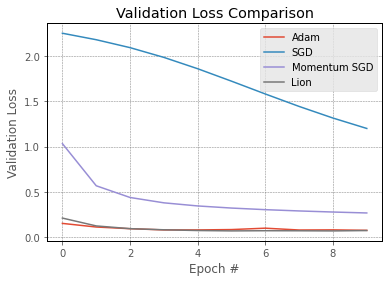

In [89]:
# Plot the validation loss for all optimizers
plt.style.use("ggplot")
plt.figure()
_,ax = plt.subplots()
ax.set_facecolor("white")

for opt_name, val_loss in val_loss_results.items():
    plt.plot(val_loss, label=opt_name)

plt.title("Validation Loss Comparison")
plt.xlabel("Epoch #")
plt.ylabel("Validation Loss")
plt.legend(loc="upper right")

# Add grid and black axes
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.savefig('val_loss.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

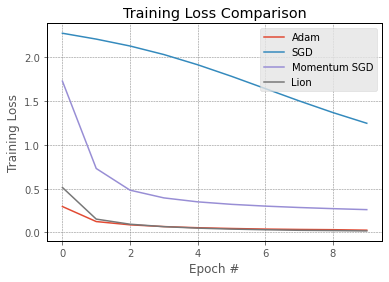

In [79]:
# Plot the training loss for all optimizers
plt.style.use("ggplot")
plt.figure()
_,ax = plt.subplots()
ax.set_facecolor("white")

for opt_name, train_loss in train_loss_results.items():
    plt.plot(train_loss, label=opt_name)

plt.title("Training Loss Comparison")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(loc="upper right")

# Add grid and black axes
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.savefig('train_loss.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

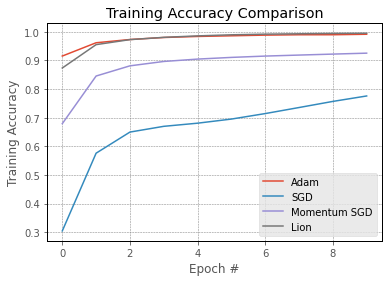

In [80]:
# Plot the training accuracy for all optimizers
plt.style.use("ggplot")
plt.figure()
_,ax = plt.subplots()
ax.set_facecolor("white")

for opt_name, train_acc in train_acc_results.items():
    plt.plot(train_acc, label=opt_name)

plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch #")
plt.ylabel("Training Accuracy")
plt.legend(loc="lower right")

# Add grid and black axes
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.savefig('train_acc.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

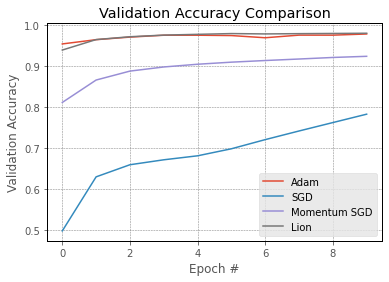

In [88]:
# Plot the validation accuracy for all optimizers
plt.style.use("ggplot")
plt.figure()
_,ax = plt.subplots()
ax.set_facecolor("white")

for opt_name, val_acc in val_acc_results.items():
    plt.plot(val_acc, label=opt_name)

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch #")
plt.ylabel("Validation Accuracy")
plt.legend(loc="lower right")

# Add grid and black axes
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.savefig('val_acc.png', dpi=300, bbox_inches='tight')
plt.show()

In [82]:
# Print SGD final validation accuracy

print("SGD validation accuracy:")
val_acc_results["SGD"][EPOCHS-1]


SGD validation accuracy:


0.7821333333333333

In [83]:
# Print Momentum SGD final validation accuracy

print("Momentum SGD validation accuracy:")
val_acc_results["Momentum SGD"][EPOCHS-1]


Momentum SGD validation accuracy:


0.9232666666666667

In [84]:
# Print Adam final validation accuracy

print("Adam validation accuracy:")
val_acc_results["Adam"][EPOCHS-1]


Adam validation accuracy:


0.9777333333333333

In [85]:
# Print Lion final validation accuracy

print("Lion validation accuracy:")
val_acc_results["Lion"][EPOCHS-1]

Lion validation accuracy:


0.9795333333333334

<Figure size 432x288 with 0 Axes>

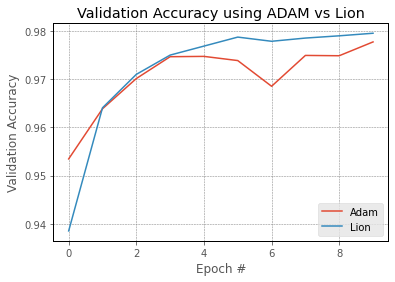

In [101]:
# Plot the validation accuracy Adam and Lion optimizers
plt.style.use("ggplot")
plt.figure()
_,ax = plt.subplots()
ax.set_facecolor("white")

optimizers_to_plot = ["Adam", "Lion"]

for opt_name, val_acc in val_acc_results.items():
    if opt_name in optimizers_to_plot:
        plt.plot(val_acc, label=opt_name)
    

plt.title("Validation Accuracy using ADAM vs Lion")
plt.xlabel("Epoch #")
plt.ylabel("Validation Accuracy")
plt.legend(loc="lower right")

# Add grid and black axes
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.savefig('val_acc_Adam_Lion.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

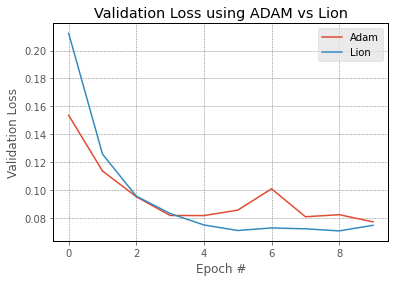

In [100]:
# Plot the validation loss for Adam and Lion optimizers
plt.style.use("ggplot")
plt.figure()
_,ax = plt.subplots()
ax.set_facecolor("white")

optimizers_to_plot = ["Adam", "Lion"]

for opt_name, val_loss in val_loss_results.items():
    if opt_name in optimizers_to_plot:
        plt.plot(val_loss, label=opt_name)

plt.title("Validation Loss using ADAM vs Lion")
plt.xlabel("Epoch #")
plt.ylabel("Validation Loss")
plt.legend(loc="upper right")

# Add grid and black axes
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.savefig('val_loss_Adam_Lion.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

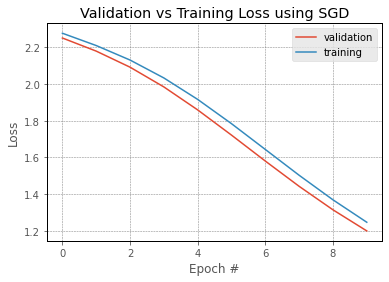

In [98]:
# Plot the training/validation loss for SGD optimizers
plt.style.use("ggplot")
plt.figure()
_,ax = plt.subplots()
ax.set_facecolor("white")

optimizers_to_plot = ["SGD"]

for opt_name, val_loss in val_loss_results.items():
    if opt_name in optimizers_to_plot:
        plt.plot(val_loss, label="validation")
            
for opt_name, train_loss in train_loss_results.items(): 
    if opt_name in optimizers_to_plot:
        plt.plot(train_loss, label="training")
        
    
plt.title("Validation vs Training Loss using SGD")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# Add grid and black axes
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.savefig('val_train_loss_SGD.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

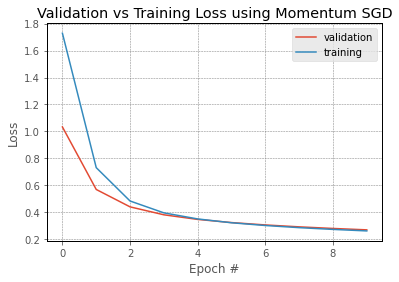

In [103]:
# Plot the training/validation loss for SGD optimizers
plt.style.use("ggplot")
plt.figure()
_,ax = plt.subplots()
ax.set_facecolor("white")

optimizers_to_plot = ["Momentum SGD"]

for opt_name, val_loss in val_loss_results.items():
    if opt_name in optimizers_to_plot:
        plt.plot(val_loss, label="validation")
            
for opt_name, train_loss in train_loss_results.items(): 
    if opt_name in optimizers_to_plot:
        plt.plot(train_loss, label="training")
        
    
plt.title("Validation vs Training Loss using Momentum SGD")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# Add grid and black axes
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.savefig('val_train_loss_Momentum_SGD.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

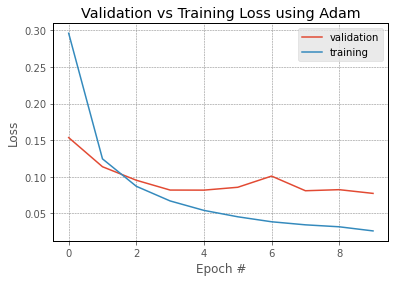

In [99]:
# Plot the training/validation loss for Adam optimizers
plt.style.use("ggplot")
plt.figure()
_,ax = plt.subplots()
ax.set_facecolor("white")

optimizers_to_plot = ["Adam"]

for opt_name, val_loss in val_loss_results.items():
    if opt_name in optimizers_to_plot:
        plt.plot(val_loss, label="validation")
            
for opt_name, train_loss in train_loss_results.items(): 
    if opt_name in optimizers_to_plot:
        plt.plot(train_loss, label="training")
        
    
plt.title("Validation vs Training Loss using Adam")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# Add grid and black axes
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.savefig('val_train_loss_Adam.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

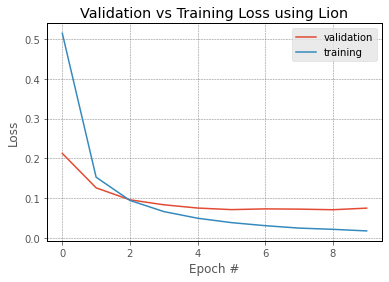

In [102]:
# Plot the training/validation loss for Adam optimizers
plt.style.use("ggplot")
plt.figure()
_,ax = plt.subplots()
ax.set_facecolor("white")

optimizers_to_plot = ["Lion"]

for opt_name, val_loss in val_loss_results.items():
    if opt_name in optimizers_to_plot:
        plt.plot(val_loss, label="validation")
            
for opt_name, train_loss in train_loss_results.items(): 
    if opt_name in optimizers_to_plot:
        plt.plot(train_loss, label="training")
        
    
plt.title("Validation vs Training Loss using Lion")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# Add grid and black axes
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.savefig('val_train_loss_Lion.png', dpi=300, bbox_inches='tight')
plt.show()